In [13]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

In [14]:
age_targets = ['0 Children', '1 Teenagers', '2 Adults', '3 Elders']

In [15]:
train_dir = './face_age_group'
data = []

for age_target in age_targets:
    age_lable = age_targets.index(age_target)
    age_path = os.path.join(train_dir,age_target)
    for img in os.listdir(age_path):
        img_path = os.path.join(age_path,img)
        train_img = plt.imread(img_path)
        try:
            image = cv2.resize(train_img,(100,100))
            np_image = np.array(image)
            data.append([np_image, age_lable])
        except Exception as e:
            pass
    
len(data)

9880

In [16]:
random.shuffle(data)

### train data has been shuffled before here 

In [17]:
features = []
labels =[]

for feature, label in data:
    features.append(feature)
    labels.append(label)

np_features = np.array(features)
np_lables = np.array(labels)

In [18]:
print(np_lables.shape,np_features.shape)

(9880,) (9880, 100, 100, 3)


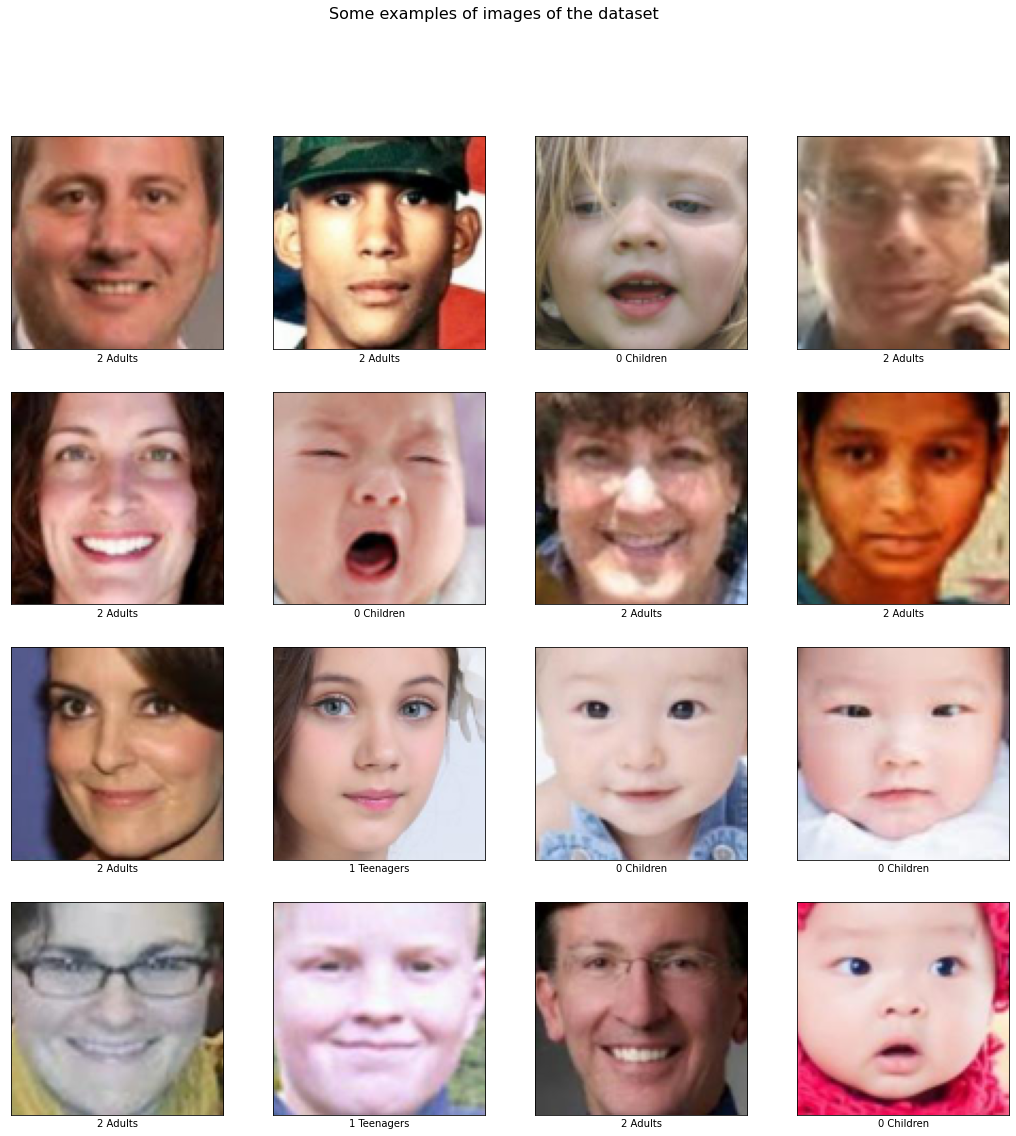

In [19]:
%matplotlib inline
fig = plt.figure(figsize=(18,18))
fig.suptitle("Some examples of images of the dataset", fontsize=16)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np_features[i], cmap=plt.cm.binary)
    plt.xlabel(age_targets[np_lables[i]])
plt.show()


In [21]:
np_lables

array([2, 2, 0, ..., 3, 0, 1])

In [22]:
from skimage.feature import hog

hog_images = []
hog_features = []
for image in np_features:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(8,8),cells_per_block=(1,1),
                       block_norm= 'L2',visualize=True, multichannel=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

In [26]:
np_hog_features = np.array(hog_features)
np_hog_images = np.array(hog_images)
print(np_hog_images.shape, np_hog_features.shape)

(9880, 100, 100) (9880, 1152)


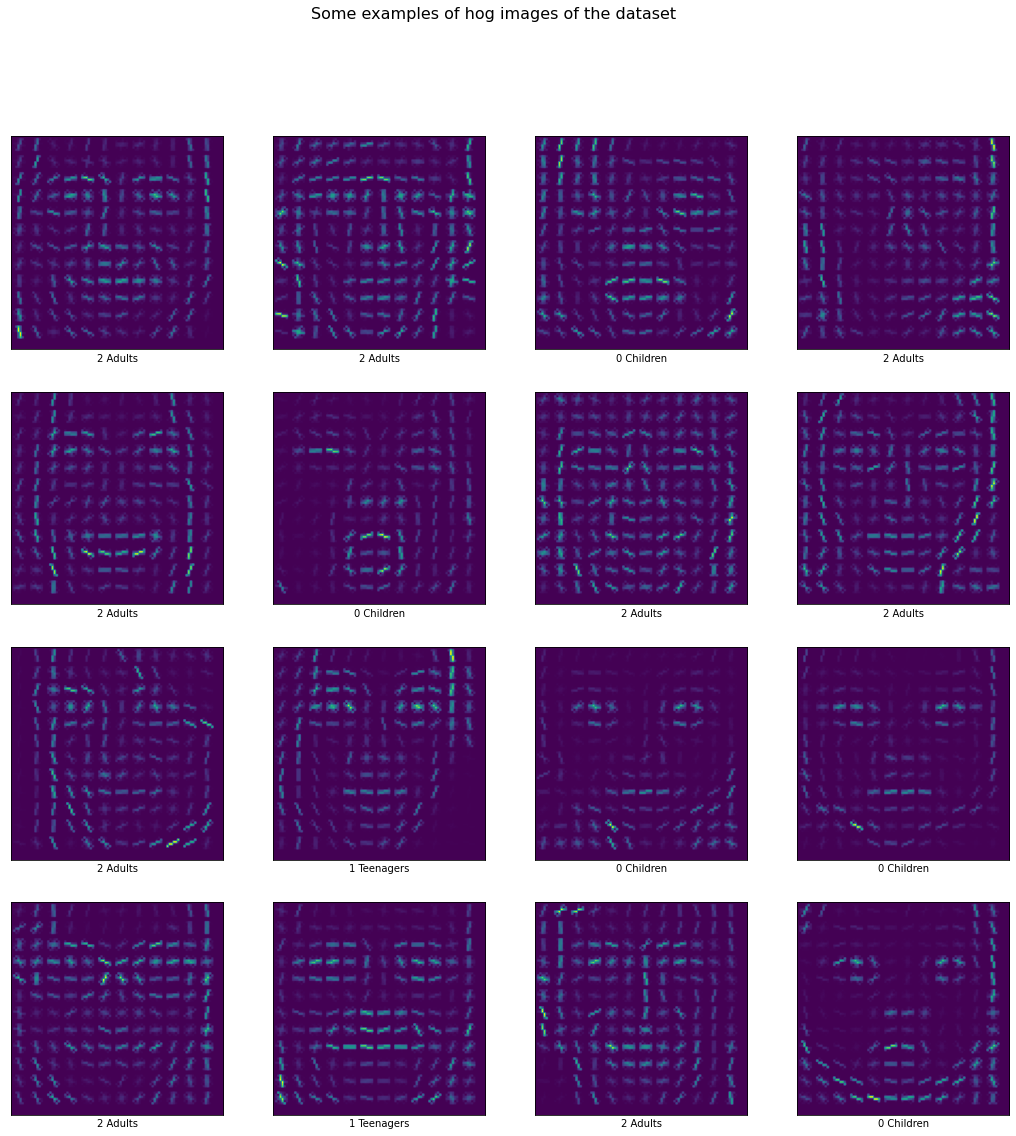

In [27]:
fig_hog = plt.figure(figsize=(18,18))
fig_hog.suptitle("Some examples of hog images of the dataset", fontsize=16)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np_hog_images[i])
    plt.xlabel(age_targets[np_lables[i]])
plt.show()

In [28]:
from sklearn.decomposition import PCA
pca_90 = PCA(n_components=0.90,svd_solver='full')
np_hog_features_pca = pca_90.fit_transform(np_hog_features)
np_hog_features_pca.shape

(9880, 610)

In [29]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(np_hog_features_pca, np_lables, test_size= 0.2)
svc_model = SVC(C=3)
svc_model.fit(X_train, y_train)
svc_model.score(X_test, y_test)

Wall time: 22.2 s


0.7899797570850202

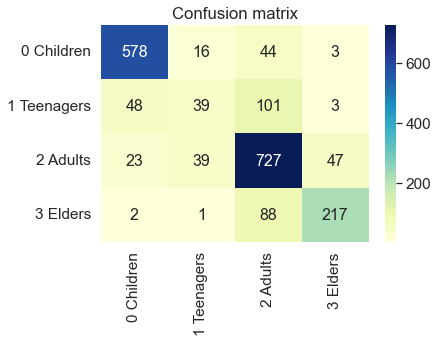

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
y_pred = svc_model.predict(X_test)
# %matplotlib inline
CM = confusion_matrix(y_test, y_pred)
ax = plt.axes()
sn.set(font_scale=1.4)
sn.heatmap(CM, annot=True,annot_kws={"size": 16},  xticklabels=age_targets, yticklabels=age_targets, ax = ax, fmt="d",cmap='YlGnBu')
ax.set_title('Confusion matrix')
plt.show()

In [32]:
def age_group_predict(face, model):
    #np_face = np.array(face)
    np_face = cv2.resize(face, (100, 100))
    plt.imshow(np_face)
    #np_face = np_face.astype(np.int32)
    fd = hog(np_face, orientations=8, pixels_per_cell=(8,8),cells_per_block=(1,1),
                       block_norm= 'L2', multichannel=True)
    #print(fd)
#     np_fd = np.array(fd)
#     print(np_fd.shape)
    np_fd_pca = pca_90.transform(fd[np.newaxis,:])
    #print(np_fd_pca.shape)
    pred_result = model.predict(np_fd_pca)
    return pred_result

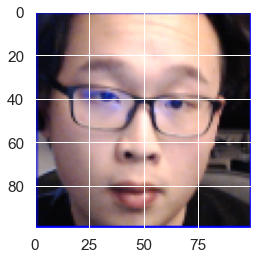

In [33]:
import cv2
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eyeCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
smileCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')

font = cv2.FONT_HERSHEY_SIMPLEX
video_capture = cv2.VideoCapture(1)

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(150,150),
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    # Draw a rectangle around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 3)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        
        roi_color = cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB)
        
        age_predit_result = age_group_predict(roi_color, svc_model)
        if age_predit_result == 0:
            cv2.putText(frame,'Children',(x, y), font, 2,(255,0,0),5)
        elif age_predit_result == 1:
            cv2.putText(frame,'Teenagers',(x, y), font, 2,(255,0,0),5)
        elif age_predit_result == 2:
            cv2.putText(frame,'Adults',(x, y), font, 2,(255,0,0),5)
        elif age_predit_result == 3:
            cv2.putText(frame,'Elders',(x, y), font, 2,(255,0,0),5)

    # smile = smileCascade.detectMultiScale(roi_gray,scaleFactor= 1.16,minNeighbors=35,minSize=(25, 25),flags=cv2.CASCADE_SCALE_IMAGE)
    # for (sx, sy, sw, sh) in smile:
    #     cv2.rectangle(roi_color, (sh, sy), (sx+sw, sy+sh), (255, 0, 0), 2)
    #     cv2.putText(frame,'Smile',(x + sx,y + sy), 1, 1, (0, 255, 0), 1)

#     eyes = eyeCascade.detectMultiScale(roi_gray,scaleFactor= 1.16,minNeighbors=20,minSize=(30, 30))
#     for (ex,ey,ew,eh) in eyes:
#         cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
#         cv2.putText(frame,'Eye',(x + ex,y + ey), 1, 1, (0, 255, 0), 1)

    cv2.putText(frame,'Number of Faces : ' + str(len(faces)),(40, 40), font, 1,(255,0,0),2)      
    # Display the resulting frame
    cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
      break

# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

In [34]:
import pickle
# save the model to disk
filename = 'svc_age_model_v1.1.h5'
pickle.dump(svc_model, open(filename, 'wb'))

In [ ]:
filename2 = 'pca_90_age_eivector.pca'
pickle.dump(pca_90, open(filename2, 'wb'))